In [1]:
from datetime import datetime

import torch

import dataset_utils as dataset
import torch as t
from ML_cup.pytorch import *

In [2]:
import os

# Check if GPU is available
if torch.cuda.is_available():
    print("GPU is available")
    torch.set_default_device(torch.device("cuda"))
print(f"Using device: {torch.cuda.current_device()}")
print(f"Available cpu count: {os.cpu_count()}")

GPU is available
Using device: 0
Available cpu count: 16


In [3]:
dev_data = dataset.load_dataset("../data/ML-CUP24-TR.csv")
blind_data = dataset.load_dataset("../data/ML-CUP24-TS.csv")

In [4]:
import time

# get a seed for the random state based on the current time
rand = int(time.time())
print(f"Random seed: {rand}")
np.random.seed(rand)

Random seed: 1740071492


In [5]:
# Split the dev data into train and validation with k-fold cross validation and minibatch
train_loaders, val_loaders, dev_loader, test_loader = dataset.torch_k_fold(dataset=dev_data, folds=5, batch_size=50,
                                                                           random_state=rand)

# Model Definitions

In [6]:
def MLP() -> t.nn.Module:
    return t.nn.Sequential(
        t.nn.Linear(12, 100),
        t.nn.ReLU(),
        t.nn.Linear(100, 100),
        t.nn.ReLU(),
        t.nn.Linear(100, 3)
    )


def MLPv2() -> t.nn.Module:
    return t.nn.Sequential(
        t.nn.Linear(12, 300),
        t.nn.ReLU(),
        t.nn.Linear(300, 300),
        t.nn.ReLU(),
        t.nn.Linear(300, 3)
    )


def MLPv3() -> t.nn.Module:
    return t.nn.Sequential(
        t.nn.Linear(12, 100),
        t.nn.ReLU(),
        t.nn.Linear(100, 100),
        t.nn.ReLU(),
        t.nn.Linear(100, 100),
        t.nn.ReLU(),
        t.nn.Linear(100, 100),
        t.nn.ReLU(),
        t.nn.Linear(100, 3)
    )

# Grid search for the best parameters

# Model v1

In [7]:
parameters = [
    {
        'optimizer': 'SGD',
        'lr': [0.0075, 0.005, 0.025],
        'weight_decay': [0.001, 0.005, 0.0015, 0.0025],
        'momentum': [0.9, 0.95],
        'nesterov': [True, False]
    },
    {
        'optimizer': 'Adam',
        'lr': [0.00075, 0.0005, 0.0003, 0.0001],
        'weight_decay': [0.0, 0.001, 0.0005]
    }
]

In [8]:
# perform grid search to find the best parameters
best_pytorch_params = grid_search(model_builder=MLP, parameters=parameters, random_seed=rand,
                                  train_loader=train_loaders,
                                  val_loader=val_loaders, max_epochs=300,
                                  scheduler=('', {}),
                                  stability_threshold=0.25, patience=10,
                                  clip=0.8,
                                  tensorboard_folder_base=f'runs/MLP/{datetime.now().strftime("%Y-%m-%d_%H-%M")}_{rand}')

Avg Train Loss: 0.3434708297252655, Avg Val Loss: 0.8603148341178894, Avg Fluctuation: 0.1212738210557845
('SGD', {'lr': 0.0075, 'weight_decay': 0.0015, 'momentum': 0.95, 'nesterov': True}, 0.8)
Avg Train Loss: 0.34930198192596434, Avg Val Loss: 0.8654546141624451, Avg Fluctuation: 0.11804677379234527
('SGD', {'lr': 0.0075, 'weight_decay': 0.0025, 'momentum': 0.95, 'nesterov': True}, 0.8)
Avg Train Loss: 0.4156622588634491, Avg Val Loss: 0.9518884062767029, Avg Fluctuation: 0.21966118817494365
('SGD', {'lr': 0.0075, 'weight_decay': 0.005, 'momentum': 0.95, 'nesterov': False}, 0.8)
Avg Train Loss: 0.32922856509685516, Avg Val Loss: 0.8320060491561889, Avg Fluctuation: 0.1840006602814553
('SGD', {'lr': 0.0075, 'weight_decay': 0.001, 'momentum': 0.95, 'nesterov': True}, 0.8)
Avg Train Loss: 0.3614823281764984, Avg Val Loss: 0.8800173997879028, Avg Fluctuation: 0.09284348810780348
('SGD', {'lr': 0.0075, 'weight_decay': 0.005, 'momentum': 0.95, 'nesterov': True}, 0.8)
Avg Train Loss: 0.3404

{'lr': 0.0001, 'weight_decay': 0.0005, 'optimizer': 'Adam'}
Fold: 0
Train Epoch: 0 Loss: 57.95802402496338
Train Epoch: 1 Loss: 57.35873222351074
Train Epoch: 2 Loss: 56.74925708770752
Train Epoch: 3 Loss: 56.161746978759766
Train Epoch: 4 Loss: 55.57499980926514
Train Epoch: 5 Loss: 54.96323585510254
Train Epoch: 6 Loss: 54.36183261871338
Train Epoch: 7 Loss: 53.75790214538574
Train Epoch: 8 Loss: 53.09764575958252
Train Epoch: 9 Loss: 52.46852779388428
Train Epoch: 10 Loss: 51.82887077331543
Train Epoch: 11 Loss: 51.217750549316406
Train Epoch: 12 Loss: 50.563180923461914
Train Epoch: 13 Loss: 49.94570350646973
Train Epoch: 14 Loss: 49.31817626953125
Train Epoch: 15 Loss: 48.66341972351074
Train Epoch: 16 Loss: 48.084259033203125
Train Epoch: 17 Loss: 47.433974266052246
Train Epoch: 18 Loss: 46.85801887512207
Train Epoch: 19 Loss: 46.2418909072876
Train Epoch: 20 Loss: 45.63462543487549
Train Epoch: 21 Loss: 45.00805854797363
Train Epoch: 22 Loss: 44.40463733673096
Train Epoch: 23 Lo

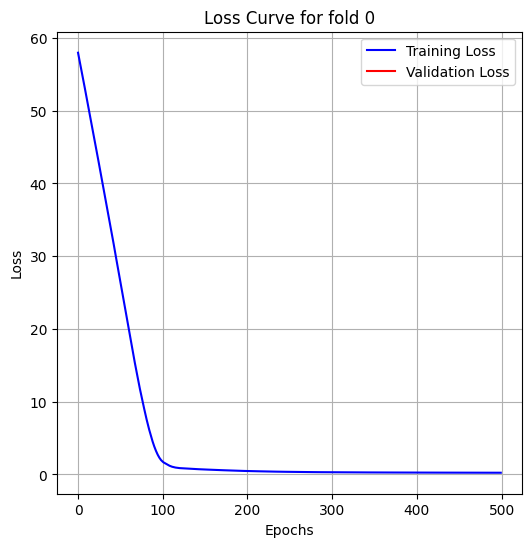

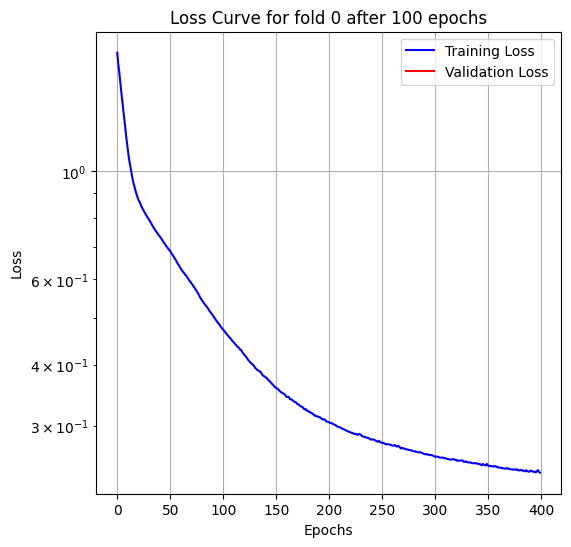

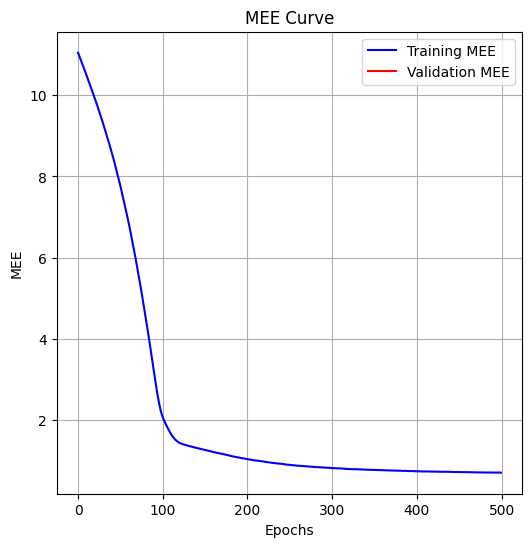

Evaluating the model on the test set
0.7817407846450806


In [10]:
# retrain the model with the best parameters
best_model = MLP()
print(best_pytorch_params)
if best_pytorch_params['optimizer'] == 'SGD':
    optimizer = t.optim.SGD(best_model.parameters(), lr=best_pytorch_params['lr'],
                            weight_decay=best_pytorch_params['weight_decay'],
                            momentum=best_pytorch_params['momentum'],
                            nesterov=best_pytorch_params['nesterov'])
else:
    optimizer = t.optim.Adam(best_model.parameters(), lr=best_pytorch_params['lr'],
                             weight_decay=best_pytorch_params['weight_decay'])

torch_train(model=best_model, optimizer=optimizer, train_loader=dev_loader,
            epochs=500, patience=20,
            verbose=True,
            clip=0.8,
            scheduler=None,
            skip_plot_points=100, random_seed=rand
            )
model_v1 = best_model
# Evaluate the trained model on the test set
print("Evaluating the model on the test set")
print(torch_predict(model_v1, test_loader))

# Model v2

In [15]:
parameters = [
    {
        'optimizer': 'SGD',
        'lr': [0.0075, 0.005, 0.025],
        'weight_decay': [0.001, 0.005, 0.0015, 0.0025],
        'momentum': [0.9, 0.95],
        'nesterov': [True, False]
    },
    {
        'optimizer': 'Adam',
        'lr': [0.00075, 0.0005, 0.0003, 0.0001],
        'weight_decay': [0.0, 0.001, 0.0005]
    }
]
# perform grid search to find the best parameters
best_pytorch_params = grid_search(model_builder=MLPv2, parameters=parameters, train_loader=train_loaders,
                                  val_loader=val_loaders, scheduler=('', {}),
                                  patience=20, clip=0.8, stability_threshold=0.2,
                                  tensorboard_folder_base=f'runs/MLP2/{datetime.now().strftime("%Y-%m-%d_%H-%M")}_{rand}',
                                  random_seed=rand)

Avg Train Loss: 0.34336023330688475, Avg Val Loss: 0.8554564952850342, Avg Fluctuation: 0.08412038875748926
('SGD', {'lr': 0.0075, 'weight_decay': 0.0025, 'momentum': 0.95, 'nesterov': True}, 0.8)
Avg Train Loss: 0.3479416072368622, Avg Val Loss: 0.8485528945922851, Avg Fluctuation: 0.02431272459548706
('SGD', {'lr': 0.0075, 'weight_decay': 0.001, 'momentum': 0.9, 'nesterov': False}, 0.8)
Avg Train Loss: 0.340850031375885, Avg Val Loss: 0.8432859420776367, Avg Fluctuation: 0.10321583446383623
('SGD', {'lr': 0.005, 'weight_decay': 0.001, 'momentum': 0.95, 'nesterov': False}, 0.8)
Avg Train Loss: 0.3733109086751938, Avg Val Loss: 0.8895240783691406, Avg Fluctuation: 0.138999286589813
('SGD', {'lr': 0.0075, 'weight_decay': 0.0025, 'momentum': 0.95, 'nesterov': False}, 0.8)
Avg Train Loss: 0.3716302037239075, Avg Val Loss: 0.892508578300476, Avg Fluctuation: 0.03557334100131435
('SGD', {'lr': 0.0075, 'weight_decay': 0.005, 'momentum': 0.9, 'nesterov': False}, 0.8)
Avg Train Loss: 0.3925918

{'lr': 0.0001, 'weight_decay': 0.0005, 'optimizer': 'Adam'}
Fold: 0
Train Epoch: 0 Loss: 51.67888927459717
Train Epoch: 1 Loss: 49.05786991119385
Train Epoch: 2 Loss: 46.28007125854492
Train Epoch: 3 Loss: 43.637248516082764
Train Epoch: 4 Loss: 41.224674224853516
Train Epoch: 5 Loss: 38.958054542541504
Train Epoch: 6 Loss: 36.71663188934326
Train Epoch: 7 Loss: 34.57299613952637
Train Epoch: 8 Loss: 32.44633102416992
Train Epoch: 9 Loss: 30.48686695098877
Train Epoch: 10 Loss: 28.48480796813965
Train Epoch: 11 Loss: 26.677120685577393
Train Epoch: 12 Loss: 24.721906185150146
Train Epoch: 13 Loss: 22.83856439590454
Train Epoch: 14 Loss: 21.102752685546875
Train Epoch: 15 Loss: 19.408936500549316
Train Epoch: 16 Loss: 17.604682683944702
Train Epoch: 17 Loss: 15.92901873588562
Train Epoch: 18 Loss: 14.39901614189148
Train Epoch: 19 Loss: 12.939376831054688
Train Epoch: 20 Loss: 11.443939447402954
Train Epoch: 21 Loss: 10.072898387908936
Train Epoch: 22 Loss: 8.830836534500122
Train Epoch

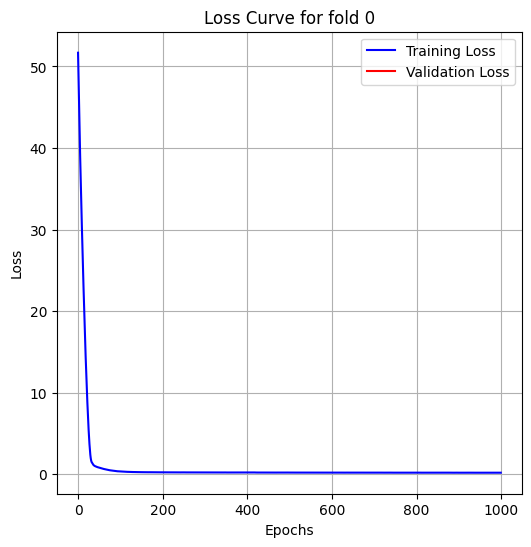

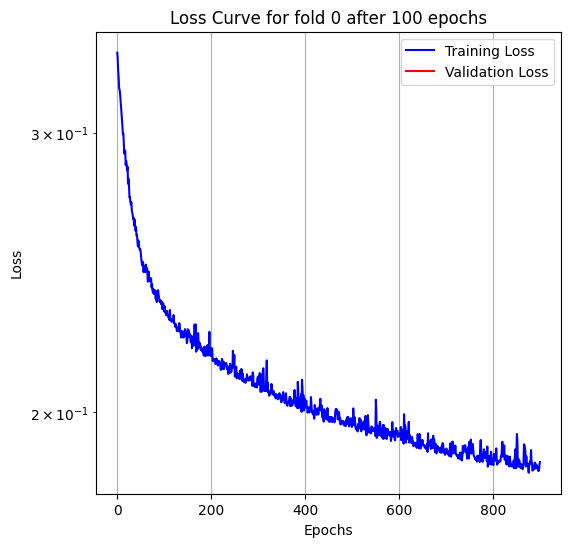

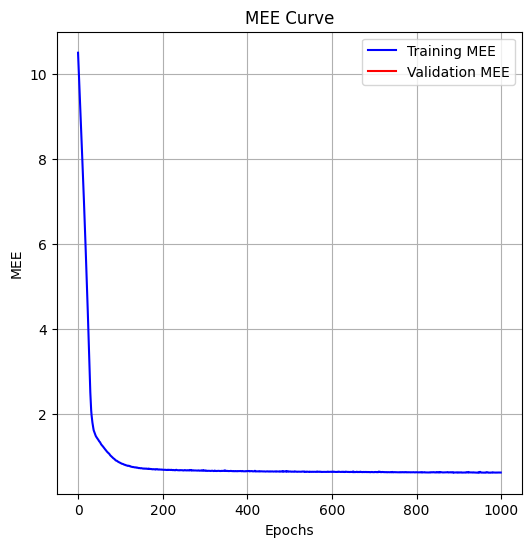

In [16]:
# retrain the model with the best parameters
#best_pytorch_params = {'lr': 0.001, 'weight_decay': 0.005, 'momentum': 0.9, 'nesterov': True, 'optimizer': 'SGD'}
print(best_pytorch_params)
best_model = MLPv2()
if best_pytorch_params['optimizer'] == 'SGD':
    optimizer = t.optim.SGD(best_model.parameters(), lr=best_pytorch_params['lr'],
                            weight_decay=best_pytorch_params['weight_decay'], momentum=best_pytorch_params['momentum'],
                            nesterov=best_pytorch_params['nesterov'])
else:
    optimizer = t.optim.Adam(best_model.parameters(), lr=best_pytorch_params['lr'],
                             weight_decay=best_pytorch_params['weight_decay'])

torch_train(model=best_model, optimizer=optimizer, train_loader=dev_loader,
            epochs=1000,
            verbose=True,
            clip=.80, skip_plot_points=100,
            patience=20, random_seed=rand,
            scheduler=None)

model_v2 = best_model

# Model v3

In [18]:

# perform grid search to find the best parameters
best_pytorch_params = grid_search(model_builder=MLPv3, parameters=parameters, train_loader=train_loaders,
                                  val_loader=val_loaders,
                                  scheduler=('', {}),
                                  clip=1.5, max_epochs=500,
                                  stability_threshold=0.5, patience=20,
                                  tensorboard_folder_base=f'runs/MLP3_s2/{datetime.now().strftime("%Y-%m-%d_%H-%M")}_{rand}',
                                  random_seed=rand)

Avg Train Loss: 0.9501120567321777, Avg Val Loss: 1.5114927530288695, Avg Fluctuation: 0.2427546991667085
('SGD', {'lr': 0.0075, 'weight_decay': 0.005, 'momentum': 0.9, 'nesterov': False}, 1.5)
Avg Train Loss: 0.4105518162250519, Avg Val Loss: 0.9336786508560181, Avg Fluctuation: 0.09958045279620804
('SGD', {'lr': 0.0075, 'weight_decay': 0.001, 'momentum': 0.9, 'nesterov': True}, 1.5)
Avg Train Loss: 0.46990799307823183, Avg Val Loss: 0.9950193285942077, Avg Fluctuation: 0.374590100838884
('SGD', {'lr': 0.0075, 'weight_decay': 0.001, 'momentum': 0.95, 'nesterov': True}, 1.5)
Avg Train Loss: 0.4700256288051605, Avg Val Loss: 0.9844574213027955, Avg Fluctuation: 0.06517691368421079
('SGD', {'lr': 0.005, 'weight_decay': 0.001, 'momentum': 0.9, 'nesterov': True}, 1.5)
Avg Train Loss: 0.6398411333560944, Avg Val Loss: 1.1928164601325988, Avg Fluctuation: 0.18304972676123607
('SGD', {'lr': 0.0075, 'weight_decay': 0.0015, 'momentum': 0.9, 'nesterov': False}, 1.5)
Avg Train Loss: 0.65747725963

{'lr': 0.0001, 'weight_decay': 0.0005, 'optimizer': 'Adam'}
Fold: 0
Train Epoch: 0 Loss: 56.19430923461914
Train Epoch: 1 Loss: 56.001888275146484
Train Epoch: 2 Loss: 55.822025299072266
Train Epoch: 3 Loss: 55.629770278930664
Train Epoch: 4 Loss: 55.448997497558594
Train Epoch: 5 Loss: 55.26207637786865
Train Epoch: 6 Loss: 55.06907272338867
Train Epoch: 7 Loss: 54.84821128845215
Train Epoch: 8 Loss: 54.62868785858154
Train Epoch: 9 Loss: 54.38408946990967
Train Epoch: 10 Loss: 54.12140464782715
Train Epoch: 11 Loss: 53.83168411254883
Train Epoch: 12 Loss: 53.49723815917969
Train Epoch: 13 Loss: 53.15783977508545
Train Epoch: 14 Loss: 52.75220775604248
Train Epoch: 15 Loss: 52.3575439453125
Train Epoch: 16 Loss: 51.91916465759277
Train Epoch: 17 Loss: 51.42329025268555
Train Epoch: 18 Loss: 50.901535987854004
Train Epoch: 19 Loss: 50.351284980773926
Train Epoch: 20 Loss: 49.7430944442749
Train Epoch: 21 Loss: 49.0942964553833
Train Epoch: 22 Loss: 48.42014026641846
Train Epoch: 23 Los

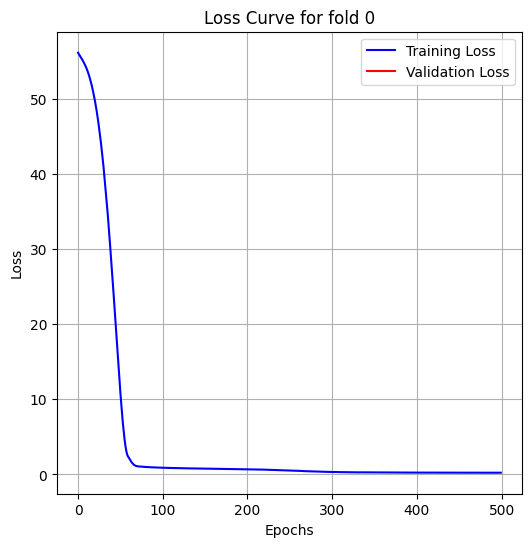

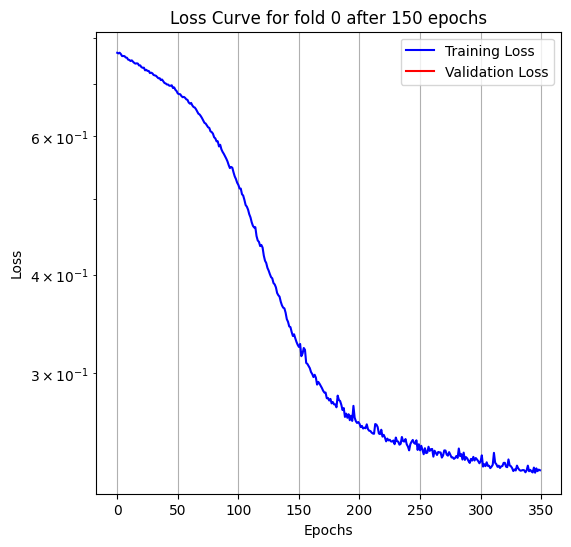

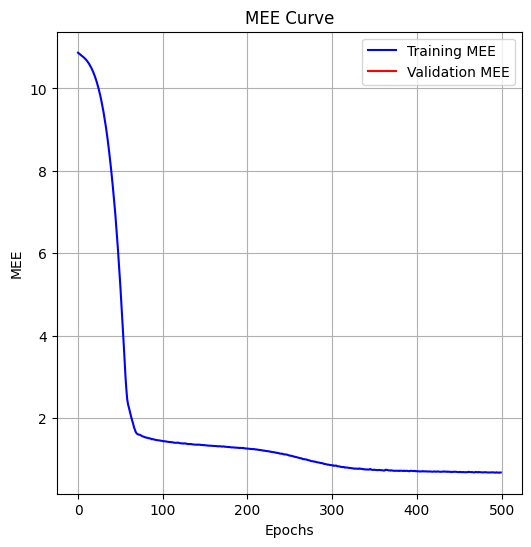

In [19]:
# retrain the model with the best parameters
# best_pytorch_params = {'lr': 0.001, 'weight_decay': 0.005, 'momentum': 0.9, 'nesterov': True, 'optimizer': 'SGD'}
print(best_pytorch_params)
best_model = MLPv3()

if best_pytorch_params['optimizer'] == 'SGD':
    optimizer = t.optim.SGD(best_model.parameters(), lr=best_pytorch_params['lr'],
                            weight_decay=best_pytorch_params['weight_decay'], momentum=best_pytorch_params['momentum'],
                            nesterov=best_pytorch_params['nesterov'])
else:
    optimizer = t.optim.Adam(best_model.parameters(), lr=best_pytorch_params['lr'],
                             weight_decay=best_pytorch_params['weight_decay'])

torch_train(model=best_model, optimizer=optimizer, train_loader=dev_loader,
            epochs=500,
            verbose=True,
            skip_plot_points=150,
            scheduler=None, clip=1.5, patience=20,
            random_seed=rand)

model_v3 = best_model

# Ensemble test

In [20]:
def torch_pred(model, test_loader: DataLoader):
    # evaluate the model on the test set using mee metric
    predictions = []
    true = []
    with torch.no_grad():
        for data, true in test_loader:
            output = model(data)
            predictions.append(output)
    return predictions, true


In [28]:
# find the a,b parameters that give the best result of a * model1 + b * model3
def find_best_a_b(predictions1, predictions3, y_dev):
    best_a = 0
    best_b = 0
    best_mee = 100

    for a in np.linspace(0, 1, 100):
        for b in np.linspace(0, 1, 100):
            if a + b == 1:
                pred = a * predictions1.cpu() + b * predictions3.cpu()
                mee = torch.norm(pred - y_dev, dim=-1).mean().item()
                print(mee)
                if mee < best_mee:
                    best_mee = mee
                    best_a = a
                    best_b = b
    return best_a, best_b, best_mee


#alfa, beta, _ = find_best_a_b(torch.stack(predictions1), torch.stack(predictions3), true.cpu())
#print(alfa, beta)

0.8547755479812622
0.8517863750457764
0.8488072752952576
0.8458383083343506
0.8428797721862793
0.8369947075843811
0.8340682983398438
0.8311527371406555
0.8282484412193298
0.8224737048149109
0.8196035623550415
0.8167452812194824
0.8138988018035889
0.811064600944519
0.8082426190376282
0.8026363849639893
0.7998524308204651
0.7970818281173706
0.7943243384361267
0.7915806770324707
0.7888507843017578
0.7861350178718567
0.7834335565567017
0.7807469367980957
0.7780753970146179
0.775419294834137
0.772779107093811
0.7701550126075745
0.7675477862358093
0.7649580240249634
0.7623862624168396
0.7598330974578857
0.7572994828224182
0.7547863721847534
0.7522945404052734
0.749825119972229
0.7473792433738708
0.7449577450752258
0.7425615787506104
0.7401914000511169
0.7378474473953247
0.7355302572250366
0.7332394123077393
0.7309742569923401
0.7287349104881287
0.7265205383300781
0.7243308424949646
0.722165584564209
0.7200242877006531
0.7179067134857178
0.715813398361206
0.7137437462806702
0.7116982936859131

In [29]:
# predict for model 1 and 3
predictions1, true = torch_pred(model_v1, test_loader)
predictions3, _ = torch_pred(model_v3, test_loader)
#alfa = 0.8787878787878789
#beta = 0.12121212121212122

#combined_predictions = alfa * torch.stack(predictions1) + beta * torch.stack(predictions3)

# CUP TEST

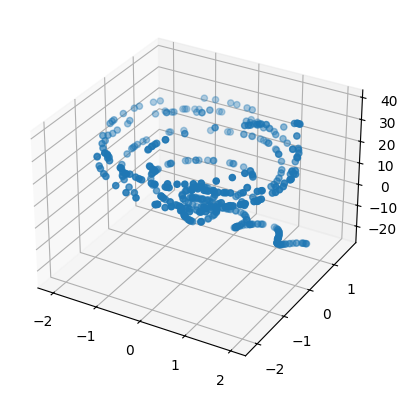

In [23]:
from ML_cup.dataset_utils import CupDataset

test_loader = DataLoader(CupDataset(blind_data, device=torch.device('cuda')))

# plot twist, it's only the inputs, that's why it's called blind

# Evaluate the trained model on the test set, and save the predictions.
model = best_model
torch.manual_seed(rand)
model.eval()  # Set the model to evaluation mode

outputs = []
with torch.no_grad():
    for inputs, labels in test_loader:
        output = model(inputs)
        outputs.append(output)

# plot the predictions in a 3d space
outputs = torch.stack(outputs).squeeze().cpu().numpy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(outputs[:, 0], outputs[:, 1], outputs[:, 2])
plt.show()

In [12]:
# save the predictions to a file
np.savetxt('predictions.csv', outputs, delimiter=',', fmt='%f')

In [13]:
# save the model
torch.save(model, 'model.pth')